# Detecting Abuse at Scale - LSH at Uber Enginnering

**Credits**

This tutorial is adapted from the workflow presented in  
**“[Detecting Abuse at Scale – LSH at Uber Engineering](https://www.uber.com/blog/lsh/)”** (Ni *et al.*, 2017).


**Compatibility**

| Platform                     | Compatible | Recommended | Notes                                                                                                                                                         |
| ---------------------------- | ---------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Local (e.g., M1 MacBook)** | ✅ Yes      | ✅ Yes       | -  |
| **Google Colab**             | ✅ Yes      | ✅ Yes       |  - |
| **Midway3 Login Node**       | ✅ Yes      | ✅ Yes       | - |
| **Midway3 Compute Node**     | ✅ Yes      | ✅ Yes      | -  |

In [ ]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName("Uber-LSH-Tutorial")
         .getOrCreate())

spark.version

'3.5.1'

With five million plus Uber trips taken daily worldwide, it is important for Uber engineers to ensure that data is accurate. If used correctly, metadata and aggregate data can quickly detect platform abuse, from spam to fake accounts and payment fraud.

In this tutorial, we will use **MinHashLSH** in Spark to detect fraudulent trips at scale through the following steps:

1. **Problem setup** – why brute‑force checks don’t scale  
2. **Trip → feature vector** engineering  
3. Building and querying a **`MinHashLSH`** model  
4. **Approximate similarity join** & **k‑nearest neighbours (ANN)**  
5. Next steps & further reading


## 1  Why LSH?  The scaling challenge

* **N² approach**: comparing each trip to every other trip is O(N²)  
  *At 5 million trips/day → ~25 trillion pairwise checks!*  
* **LSH**:
  - a randomized algorithm and hashing technique
  - hash items to group “similar” items into the **same bucket** with high probability.  
  - Sacrifice a little recall for **orders‑of‑magnitude speed‑up** (Ni *et al.* reduced runtime 55 h ➜ 4 h).

Spark provides two LSH estimators ([docs](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.html)) as shown below. In this tutorial, we will use **`MinHashLSH`** to approximate the Jaccard similarity of map‑tiles a driver visits.

| Estimator | Distance metric |
|-----------|-----------------|
| `BucketedRandomProjectionLSH` | Euclidean |
| `MinHashLSH` | Jaccard (set overlap) |


## 2  Creating a toy “trip” dataset

Each **trip** is represented by a list of **map‑tiles**. **Each map tile** is represented as a `z_x_y` strings, where `z` is the zoom level, and `x`, `y` are the coordinates at that zoom level.  For the demo, we generate a few hundred trips with controlled overlaps.

In [ ]:
import random, string
from pyspark.sql import functions as F
from pyspark.sql import types as T

random.seed(42)

In [ ]:
def random_tile():
    # fake tile id like "12_1234_5678"
    return f"{random.randint(10,15)}_{random.randint(1000,1300)}_{random.randint(4000,4300)}"

def make_trip(base_tiles, noise=0.2):
    tiles = base_tiles.copy()
    # drop some, add some
    for _ in range(int(len(base_tiles)*noise)):
        if random.random() < 0.5 and tiles:
            tiles.pop(random.randrange(len(tiles)))
        else:
            tiles.append(random_tile())
    return list(set(tiles))

n_clusters = 5
cluster_centers = [[random_tile() for _ in range(20)] for _ in range(n_clusters)]

trips=[]
for cid, center in enumerate(cluster_centers):
    for _ in range(100):  # 100 trips per cluster
        trips.append((f"trip_{cid}_{_}", make_trip(center, noise=0.3)))

schema = T.StructType([
    T.StructField("trip_id", T.StringType()),
    T.StructField("tiles", T.ArrayType(T.StringType()))
])

trip_df = spark.createDataFrame(trips, schema)
trip_df.show(5, truncate=False)

+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|trip_id |tiles                                                                                                                                                                                                                                                                                                                                           |
+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

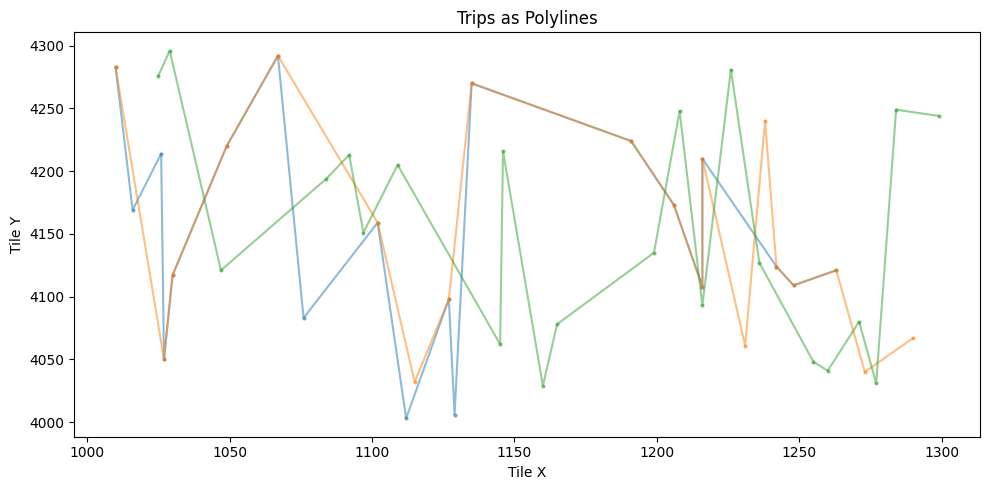

In [ ]:
import matplotlib.pyplot as plt

# Sample 100 trips (fraction: 100 / total_trips)
sampled_sdf = trip_df.sample(withReplacement=False, fraction=0.005, seed=42)
sampled_pdf = sampled_sdf.limit(100).toPandas()  # extra safety: cap to 100 rows

fig, ax = plt.subplots(figsize=(10, 5))

for _, row in sampled_pdf.iterrows():
    # Convert tile IDs to (x, y)
    points = [tuple(map(int, tile.split("_")[1:])) for tile in row['tiles']]
    if len(points) < 2:
        continue
    points = sorted(points)  # Optional: sort for smoother visuals
    xs, ys = zip(*points)
    ax.plot(xs, ys, marker='o', markersize=2, alpha=0.5)

ax.set_title("Trips as Polylines")
ax.set_xlabel("Tile X")
ax.set_ylabel("Tile Y")
plt.tight_layout()
plt.show()


## 3  Feature engineering → Sparse vectors

`MinHashLSH` expects **binary sparse vectors** (presence / absence). We:

1. Explode the `tiles` arrays  
2. Build a **`CountVectorizer`** vocabulary of the most frequent tiles  
3. Convert to sparse vectors (`features`)

> **Tip:** We treat tiles as *tokens*, re‑using Spark’s text feature pipeline.  
> See [`Tokenizer`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Tokenizer.html) and [`CountVectorizer`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html).

In [ ]:
from pyspark.ml.feature import CountVectorizer

# Since tiles are already tokens we skip Tokenizer and just feed arrays.
cv = (CountVectorizer()
      .setInputCol("tiles")
      .setOutputCol("features")
      .setVocabSize(1_000_000)
      .setMinDF(5))

cv_model = cv.fit(trip_df)
vector_df = cv_model.transform(trip_df).select("trip_id", "features")
vector_df.show(3, truncate=False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------+
|trip_id |features                                                                                                                                     |
+--------+---------------------------------------------------------------------------------------------------------------------------------------------+
|trip_0_0|(100,[3,18,29,31,32,33,37,39,50,56,58,62,66,69,77,84,86,88,97],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|trip_0_1|(100,[3,18,29,31,32,33,37,39,46,50,56,58,62,66,69,77,84,86,88],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|trip_0_2|(100,[3,18,29,31,32,33,37,46,50,56,58,62,66,69,77,84,88,97],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])       |
+--------+------------------------------------------------------------------------

## 4  Fit a `MinHashLSH` model

`MinHashLSH` parameters [(`Documentation`)](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.MinHashLSH.html):

* `inputCol`, `outputCol` – feature & hash columns  
* `numHashTables` – **OR‑amplification**: more tables → higher recall but more computation.  
  Uber used 3–5 tables; we start with 3.


In [ ]:
from pyspark.ml.feature import MinHashLSH

mh = (MinHashLSH()
      .setInputCol("features")
      .setOutputCol("hashes")
      .setNumHashTables(3))

lsh_model = mh.fit(vector_df)

hashed_df = lsh_model.transform(vector_df)
hashed_df.show(3, truncate=False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------+
|trip_id |features                                                                                                                                     |hashes                                       |
+--------+---------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------+
|trip_0_0|(100,[3,18,29,31,32,33,37,39,50,56,58,62,66,69,77,84,86,88,97],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|[[5.6356317E7], [1.1893333E8], [8.1248964E7]]|
|trip_0_1|(100,[3,18,29,31,32,33,37,39,46,50,56,58,62,66,69,77,84,86,88],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|[[5.6356317E7], [1.1893333E8], [1.0285395E8]]|
|trip

### 4.1  Approximate Nearest Neighbours (ANN)

Find the *k* trips **most similar** to a given query trip (or synthetic key).

In [ ]:
query_trip = vector_df.limit(1).collect()[0]
key_vec = query_trip['features']
k = 10

result = lsh_model.approxNearestNeighbors(dataset=vector_df, key=key_vec, numNearestNeighbors=k)
result.select("trip_id", "distCol").show()

+---------+--------------------+
|  trip_id|             distCol|
+---------+--------------------+
| trip_0_0|                 0.0|
|trip_0_44|0.050000000000000044|
|trip_0_72|0.050000000000000044|
| trip_0_1| 0.09999999999999998|
| trip_0_5| 0.09999999999999998|
|trip_0_19| 0.09999999999999998|
|trip_0_13| 0.09999999999999998|
|trip_0_26| 0.09999999999999998|
|trip_0_43| 0.09999999999999998|
|trip_0_61| 0.09999999999999998|
+---------+--------------------+



### 4.2  Approximate Similarity Join

Return **all trip pairs** whose Jaccard distance ≤ *threshold*.  
Useful for batch offline flagging of near‑duplicate trips.

In [ ]:
threshold = 0.7   # Jaccard distance => 1 - similarity
pairs_df = (lsh_model
            .approxSimilarityJoin(vector_df, vector_df, threshold)
            .filter("datasetA.trip_id < datasetB.trip_id"))  # avoid dup & self

print("Number of candidate pairs:", pairs_df.count())
pairs_df.select(
    F.col("datasetA.trip_id").alias("trip_A"),
    F.col("datasetB.trip_id").alias("trip_B"),
    F.round("distCol",3).alias("JaccardDist")
).show(10, truncate=False)

Number of candidate pairs: 23745
+---------+---------+-----------+
|trip_A   |trip_B   |JaccardDist|
+---------+---------+-----------+
|trip_1_44|trip_1_5 |0.263      |
|trip_0_3 |trip_0_6 |0.263      |
|trip_0_4 |trip_0_7 |0.45       |
|trip_0_17|trip_0_33|0.167      |
|trip_0_0 |trip_0_46|0.25       |
|trip_0_41|trip_0_67|0.167      |
|trip_0_51|trip_0_73|0.278      |
|trip_0_61|trip_0_74|0.2        |
|trip_0_64|trip_0_83|0.211      |
|trip_0_34|trip_0_85|0.2        |
+---------+---------+-----------+
only showing top 10 rows



## 5  Performance & tuning tips

| Lever | Effect |
|-------|--------|
| **`numHashTables`** | ↑ recall, ↑ runtime & shuffle |
| **Vector sparsity** | The sparser the better for MinHash |
| **Pre‑filter by bounding box / time window** | Shrink dataset before LSH |
| **AND / OR amplification** | Combine multiple LSH families for better precision ([SPARK‑18450](https://issues.apache.org/jira/browse/SPARK-18450)) |

Uber reported **~10× speed‑up** (55 h ➜ 4 h) on full production data compared with brute‑force N² joins.


## Further reading

* Ni Y. et al. (2017) “[Detecting Abuse at Scale](https://www.uber.com/blog/lsh/)” Uber Engineering blog  
* Spark ML guide – [LSH](https://spark.apache.org/docs/latest/ml-features#locality-sensitive-hashing-lsh)  
* Broder A.Z. “[On the resemblance and containment of documents](https://www.cs.princeton.edu/courses/archive/spring13/cos598C/broder97resemblance.pdf)” (1997)
